# Parameter space exploration with Latin Hypercube in R

*This tutorial assumes you have read the [tutorial on numerical integration](http://nbviewer.ipython.org/github/diogro/ode_examples/blob/master/Numerical%20Integration%20Tutorial%20-%20R.ipynb?create=1). and the [tutorial on bifurcation analysis](http://nbviewer.ipython.org/github/diogro/ode_examples/blob/master/Qualitative%20analysis%20and%20Bifurcation%20diagram%20Tutorial%20-%20R.ipynb)

## Software required
### R
*In order to run the R codes in this notebook in your own computer, you need to install the following software:*

* [R](http://www.r-project.org/), along with the packages from [CRAN](http://cran.r-project.org/):
* [deSolve](http://www.vps.fmvz.usp.br/CRAN/web/packages/deSolve/index.html), a library for solving differential equations
* [rootsolve](https://cran.r-project.org/web/packages/rootSolve/index.html): root finding and equilibrium and steady-state analyses.
* [pse](http://cran.r-project.org/web/packages/pse/), a library to run parameter space exploration of models
* [ggplot2](http://www.vps.fmvz.usp.br/CRAN/web/packages/ggplot2/index.html), a library for plotting
* [reshape2](http://cran.r-project.org/web/packages/reshape2/index.html), for manipulating data.frames

To install R, download it from its homepage (Windows or Mac): http://www.r-project.org/. On Linux, you can install it using your distribution's prefered way, e.g.:

* Debian/Ubuntu: `sudo apt-get install r-base`
* Fedora: `sudo yum install R`
* Arch: `sudo pacman -S r`

To install the packages, all you have to do is run the following in the `R` prompt

    install.packages(c("deSolve", "rootSolve, ""ggplot2", "pse"))

And then load the packages

In [48]:
library(ggplot2)
library(pse)
library(deSolve)
library(rootSolve)

#### For jupyter notebook only
options(jupyter.plot_mimetypes = 'image/png')
####

The R code presented here and some additional examples are available at https://github.com/diogro/ode_examples (thanks, [Diogro](https://github.com/diogro)!).


## Exploring the parameter space with the Latin Hypercube

### First example: two competitors in a Lotka-Volterra System

#### 1. Create a R function that runs the model once
Create a function that gets the model parameters and time sequence
and outputs the final size of populations, by numerical integration. 
If argument `runsteady=TRUE` the function uses the `runsteady` function of package *rootSolve*
to run numerical integration till a stationary point (hopefully, please see help of the function).
If `runsteady=FALSE` the function uses the `ode` function to do the integration.

In [49]:
oneRun <- function(X0, Y0, a, b,  times, runsteady=TRUE){
    ## parameters: initial sizes and competition coefficients
    parameters <- c(a = a, b = b)
    state <- c(X = X0, Y = Y0)
    ## The function to be integrated
    LV <- function(t, state, parameters){
        with(as.list(c(state, parameters)), {
            dX = X*(1 - X - a*Y)
            dY = Y*(1 - Y - b*X)
            list(c(dX, dY))
        })
    }
    ## Integrating: runsteady to run untill convergence (be carefull using that!)
    ## Or the usual integration with the function ode
    if(runsteady){
        out <- runsteady(y = state, times = times, func = LV, parms = parameters)
        return(out$y) # runsteady returns only final states
    }
    else{
        out <- ode(y = state, times = times, func = LV, parms = parameters)
        return(out[nrow(out),-1]) # indexing to get final state values
    }
}

#### 2. Create a R function for running the model for each combination of parameters
Create a function with `mapply` that gets a matrix of parameter combinations
(combinations are lines and parameters are columns)
and returns the output of the function above for each parameter combination.
Use argument `MoreArgs` to input the values for additional arguments that are not in the matrix of parameter
(arguments `runsteady` and `times` in this case).

In [50]:
modelRun <- function (my.pars) {
    return(mapply(oneRun, my.pars[,1], my.pars[,2], my.pars[,3], my.pars[,4],
                  MoreArgs=list(times=c(0,Inf), runsteady=TRUE)))
}

#### 3. Set the hypercube
Now prepare the hypercube. You have to specify:

* A character vector to name the parameters. In this case the initial conditions and the two competition coefficients

In [51]:
factors <- c("X0", "Y0", "a", "b")

* The probability quantile function used to draw values of each parameter. If you do not information on the distribution of parameters use uniform distribution to have equiprobable values in a range from `min` to `max`:

In [52]:
q <- c("qunif", "qunif", "qunif", "qunif")

* A list of the parameters of the above probability distributions. For the uniform the parameters are minimum and maximun values. So in this case each element of the list is another listwith the `max` and `min` of the corresponding model parameter, in the same order as above

In [53]:
q.arg <- list(list(min=0, max=1), list(min=0, max=1), list(min=0, max=2), list(min=0, max=2))

#### 4.  Run the hypercube
Now create the hypercube and run the model for each combination of parameters with `LHS`,
the working horse function of *pse* package.
The argument `N=200` sets 200 combinations of parameters, please see help for further information

In [54]:
myLHS <- LHS(model=modelRun, factors=factors, 
             N=200, q=q, q.arg=q.arg, nboot=100) # use nboot=0 if do not need partial correlations

#### 5. Explore your results
And now use exploratory statistics to identify interesting regions of the parameter space. The *pse* package provides some options like:

###### Cumulative distribution of outputs. 
Shows that about 40% of the population sizes are $\simeq 0$, so coexistence is not granted:

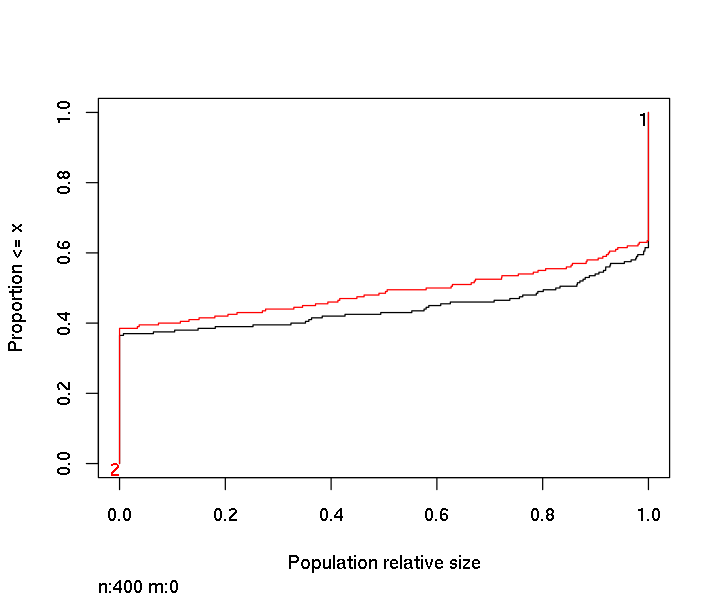

In [55]:
plotecdf(myLHS, stack=TRUE, xlab="Population relative size")

##### Scatterplots of response x parameter values
Again we see that many runs resulted in exclusion of one of the species.
We see also that initial conditions do not affect the final result, but
competition coefficients do:

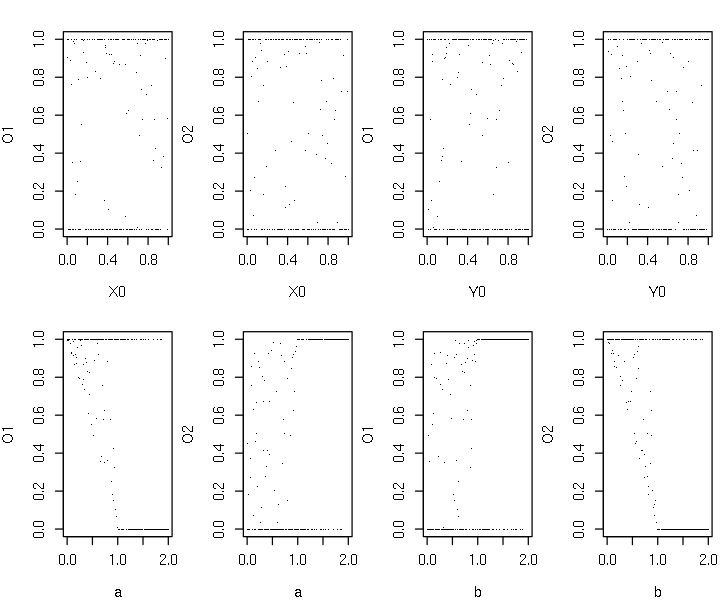

In [56]:
plotscatter(myLHS, add.lm=FALSE)

##### Partial correlation plots
Partial correlations are the non-parametric correlation of each output with each parameter,
with the effects of the other variables partialed out.
Confidence bars crossing the zero horizontal line indicate no-significant partial correlation.
These plots show that final population sizes have a strong correlation with competition coefficients.

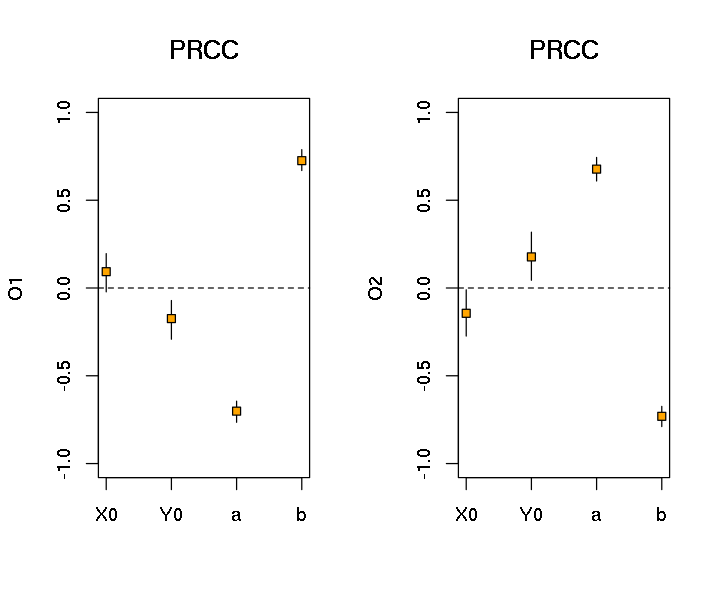

In [57]:
plotprcc(myLHS)

##### Non-standard analyses
The package *pse* allows to extract a table with the outputs for each combination of parameters.

In [58]:
## get.data export a table with parameter values
hypercube <- get.data(myLHS)

## get.results exports the outputs
hypercube <- cbind(hypercube, get.results(myLHS)) # appending columns of outputs to the hypercube matrix
names(hypercube)[5:6] <- c("X", "Y") # cosmetic

And now you are free to use any exploratory tool to identify interesting regions of the parameter space
There is not a single recipe, but a first guess is to try univariate and then bivariate and multivariate analyses.
In some case you can also use linear models such as multiple regressions to identify patterns.

For instance, we already know that there is coexistence in this parameter space.
But in how many runs?

In [59]:
sum(hypercube$X>1e-6&hypercube$Y>1e-6)

[1] 52

Which parameter combinations ensue coexistence?
Univariate exploration with boxplot shows that
there is an upper bound of coefficients to have coexistence

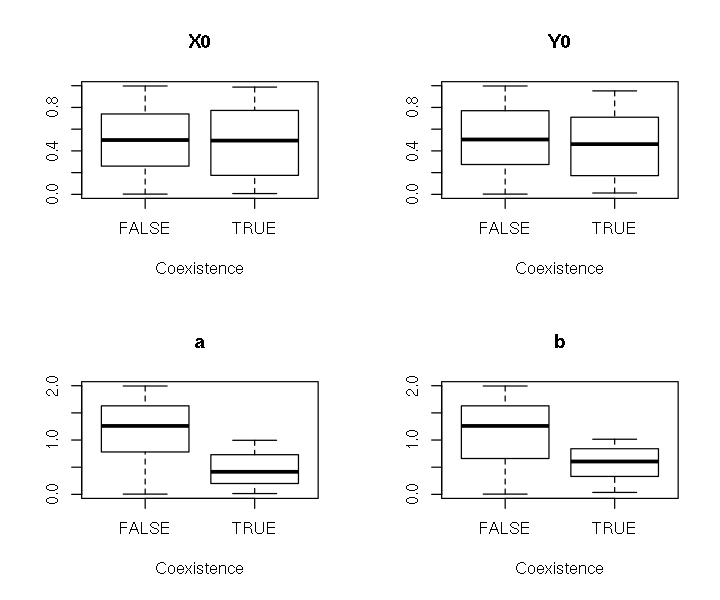

In [60]:
## Create a logical variable to flag coexistence
hypercube$coexistence <- hypercube$X>1e-6&hypercube$Y>1e-6
## boxplots
par(mfrow=c(2,2))
boxplot(X0~coexistence, data=hypercube, xlab="Coexistence", main="X0")
boxplot(Y0~coexistence, data=hypercube, xlab="Coexistence", main="Y0")
boxplot(a~coexistence, data=hypercube, xlab="Coexistence", main="a")
boxplot(b~coexistence, data=hypercube, xlab="Coexistence", main="b")
par(mfrow=c(1,1))

Bivariate plots shows that coexistence is possible only if both  coeficients are less than one, roughly (blue dots):

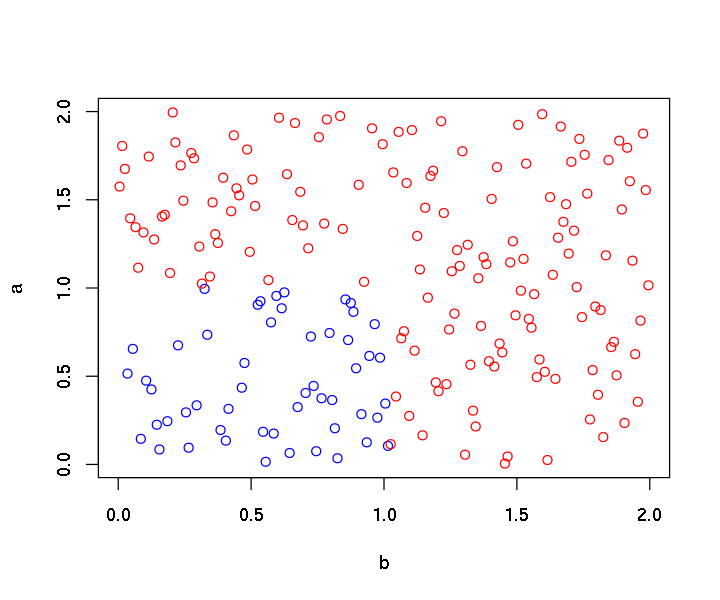

In [61]:
plot(a~b, data=hypercube, type="n") ## to scale the plot for the whole parameter space
points(a~b, data=hypercube, subset=hypercube$X>1e-6&hypercube$Y>1e-6, col="blue")
points(a~b, data=hypercube, subset=!(hypercube$X>1e-6&hypercube$Y>1e-6), col="red")


Further exploration can  reveal more!

### A more complicated example

Let's check a well-known result: in which conditions disease spreads in a Suscetible-Infected-Recovered epidemic model (SIR). 

#### 1. R function for the model

In [62]:
oneRun.sir <- function(S0, I0, R0, r, a, time=seq(0, 50, by = 0.01)){
    ## parameters: transmission and recovering rates
    parameters <- c(r = r, a = a)
    ## initial population sizes: start with a single infected individual to test invasibility
    state <- c(S = S0, I = I0, R = R0)
    ## The function to be integrated
    sir <- function(t, state, parameters){
        with(as.list(c(state, parameters)), {
            dS = -r*S*I
            dI = r*S*I - a*I
            dR = a*I
            list(c(dS, dI, dR))
        })
    }
    ## Integrating
    out <- ode(y = state, times = time, func = sir, parms = parameters)
    return(any(out[,3]>I0)) # returns a logical: any infected number larger than initial number?
}

#### 2. R function to run the model for each parameter combinations
As we are interested in disease spread we restrict I0 to one and R0 to zero.

In [63]:
modelRun.sir <- function (my.pars) {
    return(mapply(oneRun.sir, my.pars[,1], 1, 0, my.pars[,2], my.pars[,3]))
}

#### 3. Set the hypercube

In [64]:
## A string vector to name the parameters
factors <- c("S0", "r", "a")
## The probability quantile function used to draw values of each parameter
q <- c("qunif", "qunif", "qunif")
## A list of the parameters of the above probability distributions
q.arg <- list(list(min=10, max=200), list(min=0.001, max=0.01), list(min=0, max=1))

#### 4. Run the hypercube

In [65]:
myLHS <- LHS(model=modelRun.sir, factors=factors, N=200, q=q, q.arg=q.arg)

#### 5. Explore the results
Let's start looking at the effect of each parameter.
with a boxplot of each parameter value in function of the occurrence of disease spread.

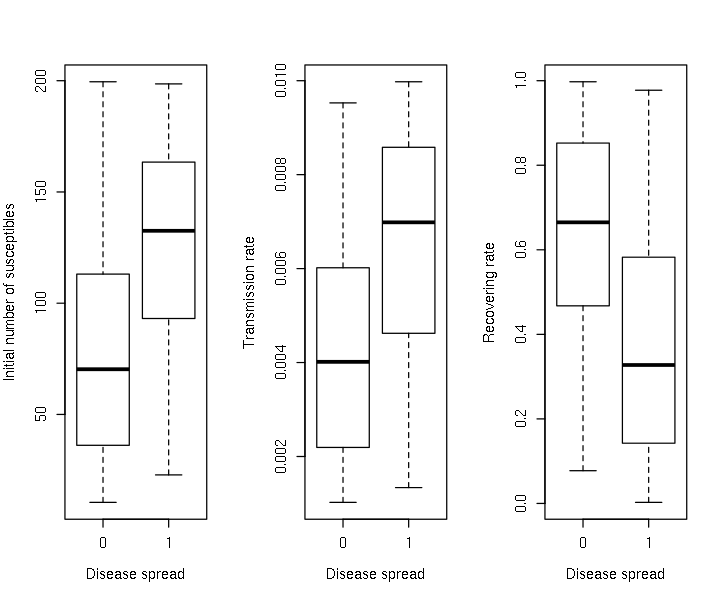

In [66]:
##Table of parameter combinations with get.data
hypercube <- get.data(myLHS)
## adding the output for each combination with get.results
hypercube$Spread <- get.results(myLHS)
## box plots parameter ~ occurence of spread (logical)
par(mfrow=c(1,3))
boxplot(S0~Spread, data=hypercube, xlab="Disease spread", ylab="Initial number of susceptibles")
boxplot(r~Spread, data=hypercube, xlab="Disease spread", ylab="Transmission rate")
boxplot(a~Spread, data=hypercube, xlab="Disease spread", ylab="Recovering rate")
par(mfrow=c(1,1))


You can also explore relatioships between parameters conditioned
to the output. This is relationship of parameter $a$ and $r$ when spread occured or not.
We'll restrict our exploration to populations with initial size < median of all initial size.

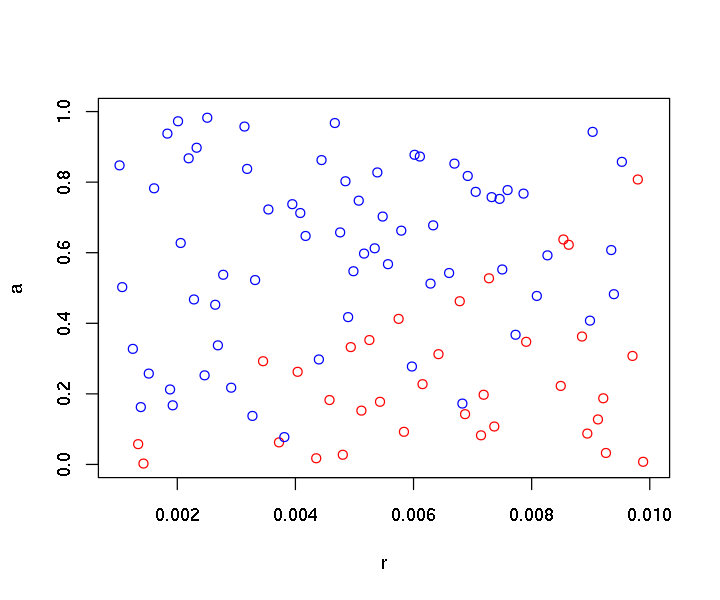

In [67]:
plot(a~r, data=hypercube, type="n") # to show all ranges of the parameters
points(a~r, data=hypercube, subset=S0<median(S0)&Spread==1, col="red")
points(a~r, data=hypercube, subset=S0<median(S0)&Spread==0, col="blue")

A next step is to explore relationships between ratios of two parameters
in function of additional parameters:

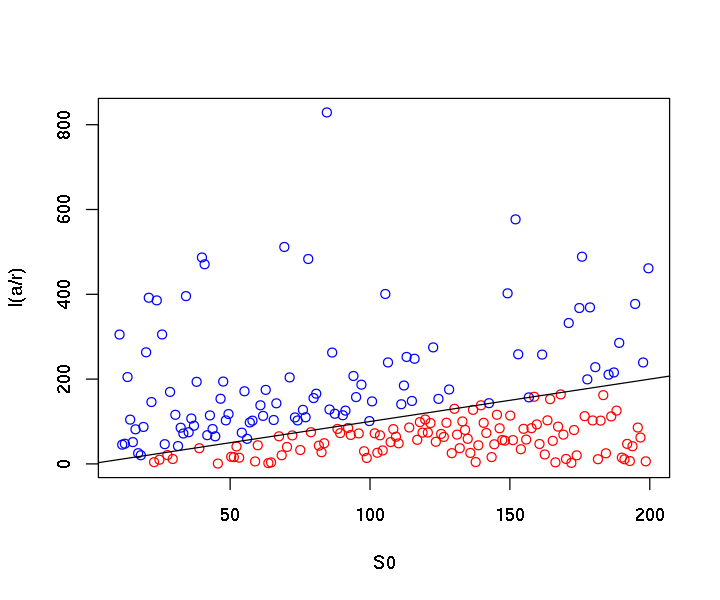

In [68]:
plot(I(a/r)~S0, data=hypercube, type="n") # to show all ranges of the parameters
points(I(a/r)~S0, subset=Spread==1, data=hypercube, col="red")
points(I(a/r)~S0, subset=Spread==0, data=hypercube, col="blue")
abline(0,1) ## equivalence line

BINGO! Disease spreads (red dots) if $S_0 > \frac{a}{r}$

### For more info:

* Chalom, A. & Prado, P.I., 2012. Parameter space exploration of ecological models. http://arxiv.org/abs/1210.6278
* [Vignette of package pse](https://cran.r-project.org/web/packages/pse/vignettes/pse_tutorial.pdf)
